In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import numpy.linalg as LA
from utils import *
from tqdm.notebook import trange, tqdm
plt.rcParams['figure.dpi'] = 150 # default for me was 75

# SINDy use on ODE

Simulate the desired ODE. In this case, we use the Lorenz '63 system.

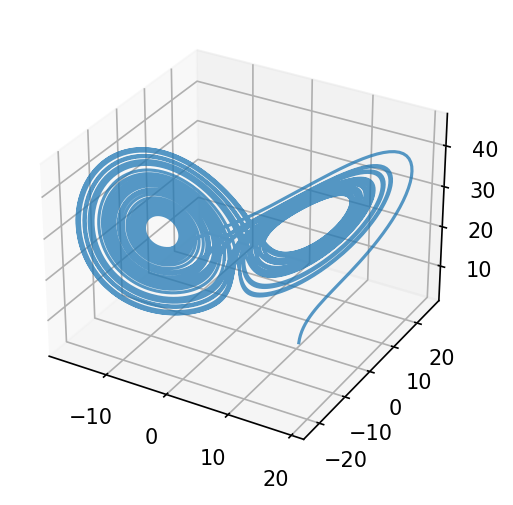

In [2]:
# Define the coefficients 
sigma = 10
alpha = 28
beta = 8/3

#Time for dynamical system simulation
tstart=0 # start time
tstop=40 # end time
meshsize=2**13
time=np.linspace(tstart,tstop,meshsize) # setting up time mesh
dt = (tstop-tstart)/meshsize


#Initial Values
IP=[10,1,2]

# Lorenz System
def Lor(X,t):
    dXdt=[sigma*(X[1]-X[0]), X[0]*(alpha-X[2])- X[1], X[0]*X[1]-beta*X[2]]
    return dXdt

# # Simulate the trajectory
A=integrate.odeint(Lor, IP, time)

# Plot the Trajectory in 3d space
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(A[:,0],A[:,1], A[:,2], alpha = .75)

Find Correlation Time:

In [3]:
def time_cor(X, dt):
      n = X.shape[0]
      cor = np.empty(int(n/2))
      mean = np.mean(X, axis = 0)
      var = np.sqrt(np.var(X, axis = 0))
      for k in range(int(n/2)):
          cor[k] = 0
          for i in range(int(n/2)):
              cor[k] += np.dot((X[i,:]-mean)/var,(X[i+k,:]-mean)/var)/(int(n/2))
          if np.sign(cor[k]) == -1:
              break
      point = k
      value = dt*point
      return point, value
 
    
point, value = time_cor(A, dt)   
print(value)

3.388671875


If you wish to modify the existing data, this would be where it is done. However, we proceed with the complete data, with no sparsity or noise modifications. To save the original simulation, we call the input to SINDy "data"

## Running SINDy

Estimate dX/dt

In [4]:
data = A

D = D_Lele(data.shape[0],tstop/data.shape[0]) # Calculate the compact-finite-difference operator
dXdt = np.empty(data.shape)
for i in trange(data.shape[1]): # iterates over each spatial component
    dXdt[:,i] = np.dot(D.toarray(), data[:,i])

Construct the library for the regression. We use $\{x,y,z\}$ as the potential functions:

In [78]:
Library = A       # if other functions (ie. sin(x_1)) are desired, then append a column sin(x_1) to the library

We then construct $\Theta$ with polynomial terms up to degree 3. 

In [79]:
total_variable = data.shape[1]
total_guesses = 1 + total_variable + sp.special.comb(total_variable, 2, repetition = True) + sp.special.comb(total_variable, 3, repetition = True)
Theta = np.empty([data.shape[0], int(total_guesses)], dtype = complex)

i = 0
Theta[:,i] = np.ones(A.shape[0])
i = i+1

for j in range(total_variable):
    Theta[:,i] = Library[:, j]
    i = i+1

# Uncomment if quadratic terms are desired 
for j in range(total_variable):
    for l in range(total_variable-j):
        Theta[:,i] = Library[:,j]*Library[:,l+j]
        i = i+1

# Uncomment if cubic terms are desired
for j in range(total_variable):
    for jj in range(total_variable-j):
        for jjj in range(total_variable-j-jj):
            Theta[:,i] = Library[:,j]*Library[:,jj+j]*Library[:,j+jj+jjj]
            i = i+1


Now, run the SINDy regression to find the sparse solution to $\dot{X} = \Theta\Xi$

In [80]:
#Solve for Coeffcients
Xi = LA.lstsq(Theta,dXdt, rcond = None)[0]

l=0.001 # Set the Threshold value 

condition = np.abs(Xi) > l # Set a condition for below threshold
Xi = np.where(condition, Xi, np.zeros(Xi.shape)) # Zero-out all elements below l

# Re-regress
for j in range(2):# 2 because that is the total number of variables
    vec = condition[:,j] # Extract first variable
    bigind = [i for i in range(len(vec)) if vec[i] == True] #Save the large values
    # Rerun the regression on the functions with components >l
    Xi[bigind, j] = LA.lstsq(Theta[:, bigind], dXdt[:,j], rcond = None)[0]
    
Print = ['1','x', 'y','z','x^2','xy','xz','y^2','yz','z^2','x^3','x^2y','x^2z','xy^2','xyz','xz^2','y^3','y^2z','yz^2','z^3']
Print_1 = []
print('          dx/dt            dy/dt           dz/dt    ')
for i in range(int(total_guesses)):
    print(Print[i], '   %.2f + %.2f i    %.2f + %.2f i    %.2f + %.2f i    ' %(Xi[i,0].real, Xi[i,0].imag, Xi[i,1].real, Xi[i,1].imag,  Xi[i,2].real, Xi[i,2].imag))

          dx/dt            dy/dt           dz/dt    
1    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
x    -10.00 + 0.00 i    28.00 + 0.00 i    0.00 + 0.00 i    
y    10.00 + 0.00 i    -1.00 + 0.00 i    0.00 + 0.00 i    
z    0.00 + 0.00 i    0.00 + 0.00 i    -2.67 + 0.00 i    
x^2    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
xy    0.00 + 0.00 i    0.00 + 0.00 i    1.00 + 0.00 i    
xz    0.00 + 0.00 i    -1.00 + 0.00 i    0.00 + 0.00 i    
y^2    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
yz    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
z^2    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
x^3    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
x^2y    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
x^2z    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
xy^2    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
xyz    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
xz^2    0.00 + 0.00 i    0.00 + 0.00 i    0.00 + 0.00 i    
y^3

Calculate error of coefficients discovered:

In [81]:
Actual = np.zeros(Xi.shape)
Actual[1,:] = [-10, 28, 0]
Actual[2,:] = [10, -1, 0]
Actual[3,:] = [0, 0, -8/3]
Actual[5,2] = 1
Actual[6,1] = -1

Error = Xi-Actual
norm_Error = LA.norm(Error)
entry_Error = np.amax(abs(Error))
print('Norm Error', norm_Error)
print('Entry Error', entry_Error)


Norm Error 0.003851231684465439
Entry Error 0.0034218349163097628


Resimulate the trajectory using the same initial conditions with the discovered coefficients:

Sim Error 64.11031070278258


Text(0.5, 1.0, 'X-Coordinate of the Original and Discovered Trajectory Over Time')

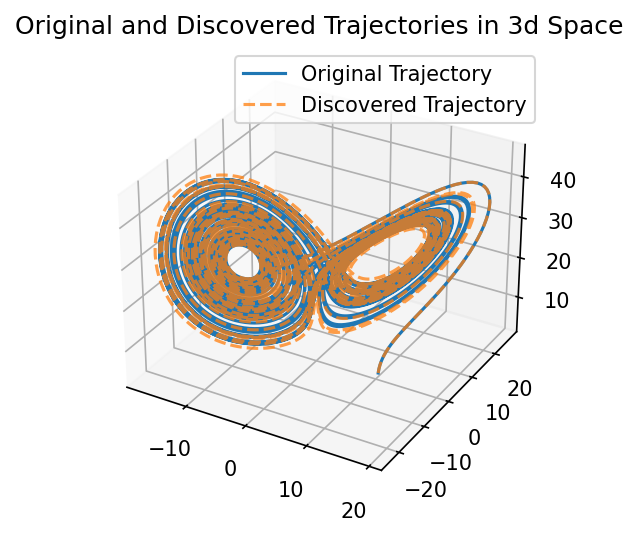

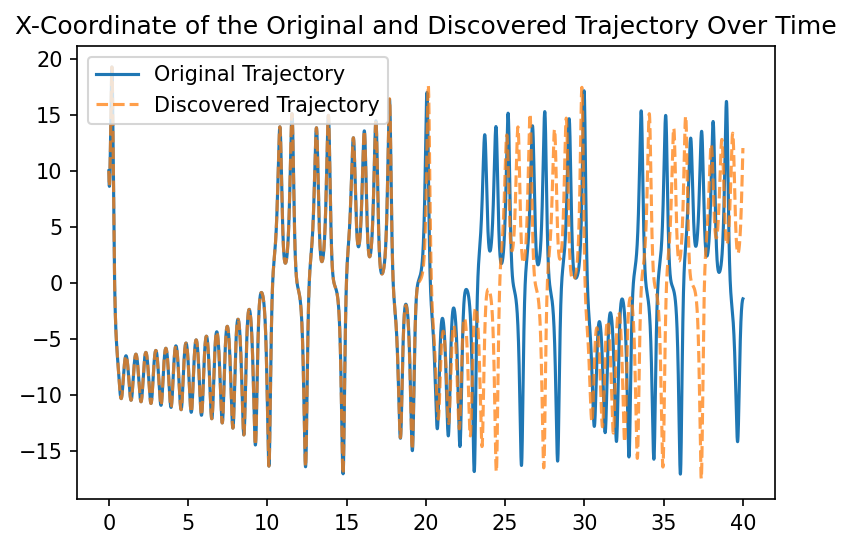

In [82]:
def reproduce(X,t,A):
    i=0
    total_variable = A.shape[1]
    Step_Vector = np.empty(A.shape[0])
    Step_Vector[0] = 1
    i+=1
    for j in range(total_variable):
        Step_Vector[i] = X[j]
        i = i+1

    # Uncomment if quadratic terms are desired 
    for j in range(total_variable):
        for l in range(total_variable-j):
            Step_Vector[i] = X[j]*X[l+j]
            i = i+1

    # Uncomment if cubic terms are desired
    for j in range(total_variable):
        for jj in range(total_variable-j):
            for jjj in range(total_variable-j-jj):
                Step_Vector[i] = X[j]*X[jj+j]*X[j+jj+jjj]
                i = i+1
    dXdt = np.empty(len(X))
    for l in range(len(X)):
        dXdt[l] = np.dot(Step_Vector, A[:,l])

    return dXdt
sim = integrate.odeint(reproduce, IP, time, args = (Xi.real,))
sim_error = LA.norm(sim[:2**12]-A[:2**12])
print('Sim Error', sim_error)
# Plot the Trajectory in 3d space
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(A[:,0],A[:,1], A[:,2], label = 'Original Trajectory')
ax.plot(sim[:,0],sim[:,1], sim[:,2], '--', label = 'Discovered Trajectory', alpha = .75)
ax.legend()
ax.set_title('Original and Discovered Trajectories in 3d Space')

fig = plt.figure()
ax = plt.axes()
ax.plot(time, A[:,0], label = 'Original Trajectory')
ax.plot(time, sim[:,0], '--', label = 'Discovered Trajectory', alpha = .75)
ax.legend()
ax.set_title('X-Coordinate of the Original and Discovered Trajectory Over Time')